
=== Локальный анализ по стадиям (S-кривая) ===
                    stage interval  n_obs  ENTER_R2 STEP_selected  STEP_R2  ENTER_B_Xn  ENTER_Beta_Xn
     1. Зарождение (<10%)     0-50     39  1.000000         [X_n]      1.0   -0.099676      -0.994135
2. Активный рост (10-50%)    50-72     11  1.000000         [X_n]      1.0   -0.099873      -1.004154
    3. Насыщение (50-95%)   72-101     18  0.999971         [X_n]      1.0   -0.100010      -1.000580
          4. Плато (>95%)  101-150     38  1.000000         [X_n]      1.0   -0.070943      -0.640854

=== Скользящее окно (ENTER) ===
   start  end   R2
0      0   25  1.0
1      1   26  1.0
2      2   27  1.0
3      3   28  1.0
4      4   29  1.0

=== Скользящее окно (STEPWISE) ===
   start  end   R2 selected
0      0   25  1.0    [X_n]
1      1   26  1.0    [X_n]
2      2   27  1.0    [X_n]
3      3   28  1.0    [X_n]
4      4   29  1.0    [X_n]


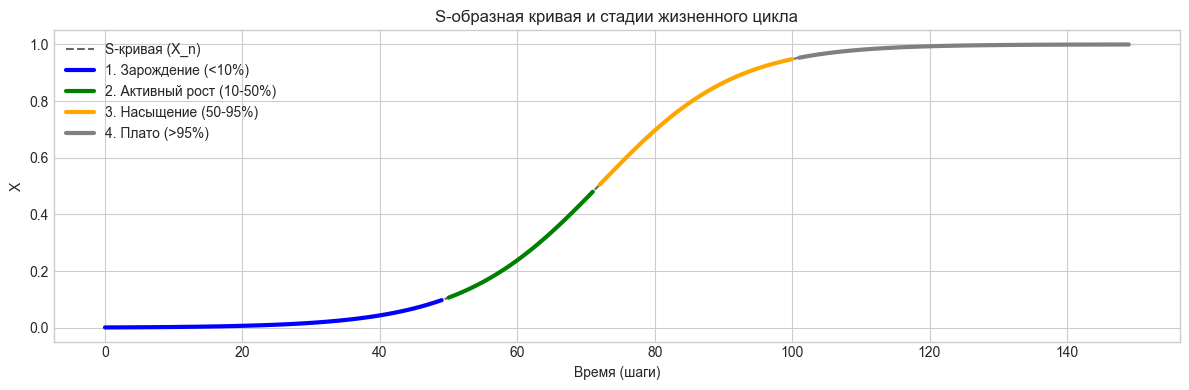

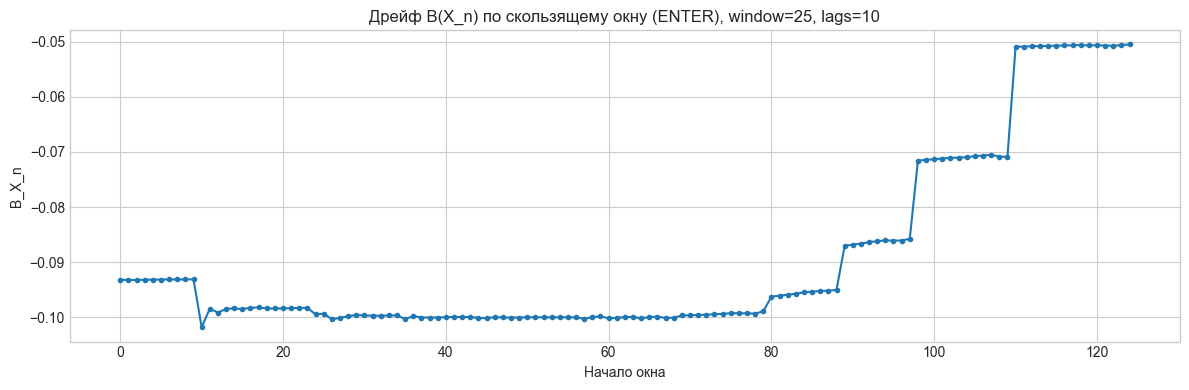

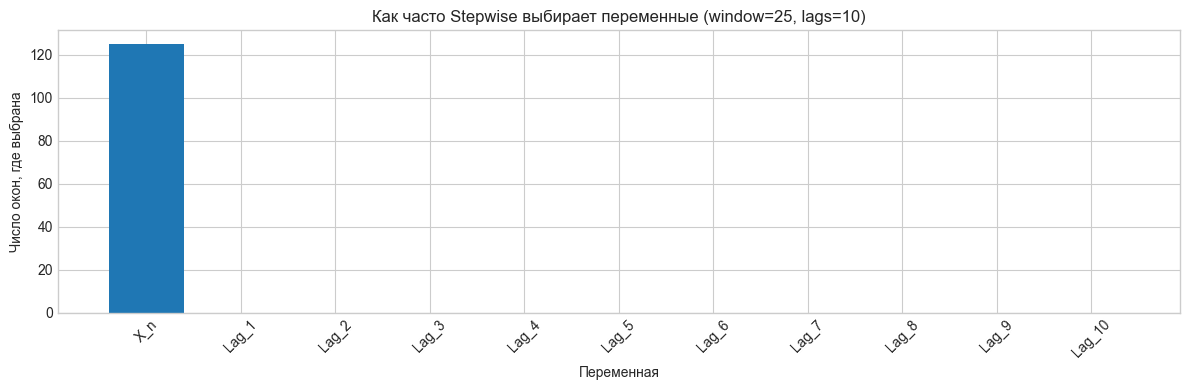

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

# =========================================================
# 1) ГЕНЕРАЦИЯ БАЗОВОЙ МОДЕЛИ (Ферхюльст в форме Полунина)
#    X_{n+1} = X_n + A*X_n*(K - X_n)
# =========================================================
def generate_process_basic(A, K=1.0, x0=0.001, steps=200):
    x = np.zeros(steps)
    x[0] = x0
    for i in range(steps - 1):
        x[i+1] = x[i] + x[i] * A * (K - x[i])
        # мягкая защита от улета (на всякий случай)
        if x[i+1] > K * 1.5:
            x[i+1] = K * 1.5
        if x[i+1] < 0:
            x[i+1] = 0
    return x

# =========================================================
# 2) СЕГМЕНТАЦИЯ "ЖИЗНЕННЫЙ ЦИКЛ" (только для S-кривой)
# =========================================================
def find_lifecycle_stages(x_series, K=1.0):
    stages = {}
    idx_startup = np.where(x_series < 0.1 * K)[0]
    idx_growth  = np.where((x_series >= 0.1 * K) & (x_series < 0.5 * K))[0]
    idx_mature  = np.where((x_series >= 0.5 * K) & (x_series < 0.95 * K))[0]
    idx_plateau = np.where(x_series >= 0.95 * K)[0]

    def get_bounds(indices):
        if len(indices) < 5:
            return None
        return (indices[0], indices[-1] + 1)

    if len(idx_startup) > 0: stages['1. Зарождение (<10%)'] = get_bounds(idx_startup)
    if len(idx_growth) > 0:  stages['2. Активный рост (10-50%)'] = get_bounds(idx_growth)
    if len(idx_mature) > 0:  stages['3. Насыщение (50-95%)'] = get_bounds(idx_mature)
    if len(idx_plateau) > 0: stages['4. Плато (>95%)'] = get_bounds(idx_plateau)
    return stages

# =========================================================
# 3) STEPWISE (по p-values) — как "шаговый отбор" в SPSS
# =========================================================
def stepwise_selection(X, y, initial_list=None, threshold_in=0.01, threshold_out=0.05):
    if initial_list is None:
        initial_list = []
    included = list(initial_list)

    while True:
        changed = False

        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index=excluded, dtype=float)

        for new_column in excluded:
            try:
                model = sm.OLS(y, sm.add_constant(X[included + [new_column]])).fit()
                new_pval[new_column] = model.pvalues[new_column]
            except:
                continue

        if not new_pval.empty:
            best_pval = new_pval.min()
            if best_pval < threshold_in:
                best_feature = new_pval.idxmin()
                included.append(best_feature)
                changed = True

        # backward step
        if included:
            model = sm.OLS(y, sm.add_constant(X[included])).fit()
            pvalues = model.pvalues.iloc[1:]  # exclude constant
            worst_pval = pvalues.max() if not pvalues.empty else None

            if worst_pval is not None and worst_pval > threshold_out:
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                changed = True

        if not changed:
            break

    return included

# =========================================================
# 4) Подготовка ω_{n+1} и лагов X_n, X_{n-1}, ..., X_{n-L}
#     ω = (X_{n+1} - X_n) / X_n
# =========================================================
def make_regression_df(X, lags=10):
    X = np.asarray(X)
    Xn = X[:-1]
    Xn1 = X[1:]
    safe = Xn.copy()
    safe[safe == 0] = 1e-12
    omega = (Xn1 - Xn) / safe

    df = pd.DataFrame({'omega': omega, 'X_n': Xn})
    for l in range(1, lags + 1):
        df[f'Lag_{l}'] = pd.Series(Xn).shift(l)

    df = df.dropna().reset_index(drop=True)
    return df

# =========================================================
# 5) ENTER + Beta-коэффициенты
# =========================================================
def fit_enter_with_beta(X_mat, y):
    X_const = sm.add_constant(X_mat)
    model = sm.OLS(y, X_const).fit()

    # Beta: стандартизируем X и y
    Xs = (X_mat - X_mat.mean()) / X_mat.std(ddof=0)
    ys = (y - y.mean()) / y.std(ddof=0)
    model_beta = sm.OLS(ys, Xs).fit()

    beta = pd.Series(model_beta.params, index=X_mat.columns)
    return model, beta

# =========================================================
# 6) Окно фиксированной длины (короткие данные)
#    Возвращает таблицу параметров по окнам
# =========================================================
def rolling_window_regression(X, window=25, lags=10, method='enter'):
    """
    method: 'enter' или 'stepwise'
    """
    rows = []
    X = np.asarray(X)

    # чтобы лаги работали, внутри окна должно быть > lags+3
    min_len = lags + 5
    if window < min_len:
        raise ValueError(f"window должен быть >= {min_len}, иначе лаги не поместятся.")

    for start in range(0, len(X) - window):
        end = start + window
        segment = X[start:end]

        df = make_regression_df(segment, lags=lags)
        if len(df) < 8:
            continue

        y = df['omega']
        X_mat = df.drop(columns=['omega'])

        if method == 'enter':
            model, beta = fit_enter_with_beta(X_mat, y)
            selected = list(X_mat.columns)

        elif method == 'stepwise':
            selected = stepwise_selection(X_mat, y, threshold_in=0.01, threshold_out=0.05)
            if not selected:
                continue
            model = sm.OLS(y, sm.add_constant(X_mat[selected])).fit()

            # beta для выбранных переменных
            Xs = (X_mat[selected] - X_mat[selected].mean()) / X_mat[selected].std(ddof=0)
            ys = (y - y.mean()) / y.std(ddof=0)
            model_beta = sm.OLS(ys, Xs).fit()
            beta = pd.Series(model_beta.params, index=selected)

        else:
            raise ValueError("method must be 'enter' or 'stepwise'")

        # сохраняем ключевые показатели
        row = {
            'start': start,
            'end': end,
            'R2': model.rsquared,
            'selected': selected
        }

        # коэффициенты B
        for k, v in model.params.items():
            row[f'B_{k}'] = v

        # бета
        for k, v in beta.items():
            row[f'Beta_{k}'] = v

        rows.append(row)

    return pd.DataFrame(rows)

# =========================================================
# 7) Анализ "стадий" (как у тебя), но теперь:
#    - lags=10
#    - enter + stepwise
#    - beta коэффициенты
# =========================================================
def stagewise_lifecycle_analysis(X, stages, lags=10):
    logs = []

    for name, bounds in stages.items():
        if bounds is None:
            continue
        start, end = bounds
        segment = X[start:end]

        df = make_regression_df(segment, lags=lags)
        if len(df) < 8:
            continue

        y = df['omega']
        X_mat = df.drop(columns=['omega'])

        # ENTER
        enter_model, enter_beta = fit_enter_with_beta(X_mat, y)

        # STEPWISE
        selected = stepwise_selection(X_mat, y, threshold_in=0.01, threshold_out=0.05)
        if selected:
            step_model = sm.OLS(y, sm.add_constant(X_mat[selected])).fit()
        else:
            step_model = None

        logs.append({
            'stage': name,
            'interval': f'{start}-{end}',
            'n_obs': len(df),
            'ENTER_R2': enter_model.rsquared,
            'STEP_selected': selected,
            'STEP_R2': step_model.rsquared if step_model is not None else np.nan,
            'ENTER_B_Xn': enter_model.params.get('X_n', np.nan),
            'ENTER_Beta_Xn': enter_beta.get('X_n', np.nan),
        })

    return pd.DataFrame(logs)

# =========================================================
# ---------------------- ЗАПУСК ----------------------------
# =========================================================
K_sim = 1.0
A_sim = 0.1
steps_sim = 150
lags = 10

X_data = generate_process_basic(A_sim, K_sim, steps=steps_sim)

# 1) Жизненный цикл (стадийная сегментация) — только S-кривая
stages = find_lifecycle_stages(X_data, K_sim)
life_df = stagewise_lifecycle_analysis(X_data, stages, lags=lags)
print("\n=== Локальный анализ по стадиям (S-кривая) ===")
print(life_df.to_string(index=False))

# 2) Короткие окна фиксированной длины — "в реальности всегда коротко"
window = 25

# ENTER (полная модель)
roll_enter = rolling_window_regression(X_data, window=window, lags=lags, method='enter')
print("\n=== Скользящее окно (ENTER) ===")
print(roll_enter[['start','end','R2']].head())

# STEPWISE (выбор переменных)
roll_step = rolling_window_regression(X_data, window=window, lags=lags, method='stepwise')
print("\n=== Скользящее окно (STEPWISE) ===")
print(roll_step[['start','end','R2','selected']].head())


# --- ВИЗУАЛИЗАЦИЯ S-КРИВОЙ И СТАДИЙ ЖИЗНЕННОГО ЦИКЛА ---

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(X_data, color='black', linestyle='--', alpha=0.6, label='S-кривая (X_n)')

colors = {'1': 'blue', '2': 'green', '3': 'orange', '4': 'gray'}

for name, bounds in stages.items():
    if bounds is None:
        continue
    start, end = bounds
    stage_key = name[0]
    ax.plot(range(start, end), X_data[start:end],
            linewidth=3, color=colors[stage_key], label=name)

ax.set_title("S-образная кривая и стадии жизненного цикла")
ax.set_xlabel("Время (шаги)")
ax.set_ylabel("X")
ax.legend()
plt.tight_layout()
plt.show()


# --- ВИЗУАЛИЗАЦИЯ ДРЕЙФА КОЭФФИЦИЕНТА ---
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(roll_enter['start'], roll_enter.get('B_X_n', np.nan), marker='.', linestyle='-')
ax.set_title(f"Дрейф B(X_n) по скользящему окну (ENTER), window={window}, lags={lags}")
ax.set_xlabel("Начало окна")
ax.set_ylabel("B_X_n")
plt.tight_layout()
plt.show()

# --- ВИЗУАЛИЗАЦИЯ ЧАСТОТЫ ЛОЖНЫХ ЛАГОВ В STEPWISE ---
# Считаем, как часто выбираются Lag_k
lag_cols = [f'Lag_{i}' for i in range(1, lags+1)]
counts = {c: 0 for c in ['X_n'] + lag_cols}

for sel in roll_step['selected']:
    for v in sel:
        if v in counts:
            counts[v] += 1

counts_df = pd.DataFrame({'var': list(counts.keys()), 'count': list(counts.values())})
counts_df = counts_df.sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(12, 4))
ax.bar(counts_df['var'], counts_df['count'])
ax.set_title(f"Как часто Stepwise выбирает переменные (window={window}, lags={lags})")
ax.set_xlabel("Переменная")
ax.set_ylabel("Число окон, где выбрана")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


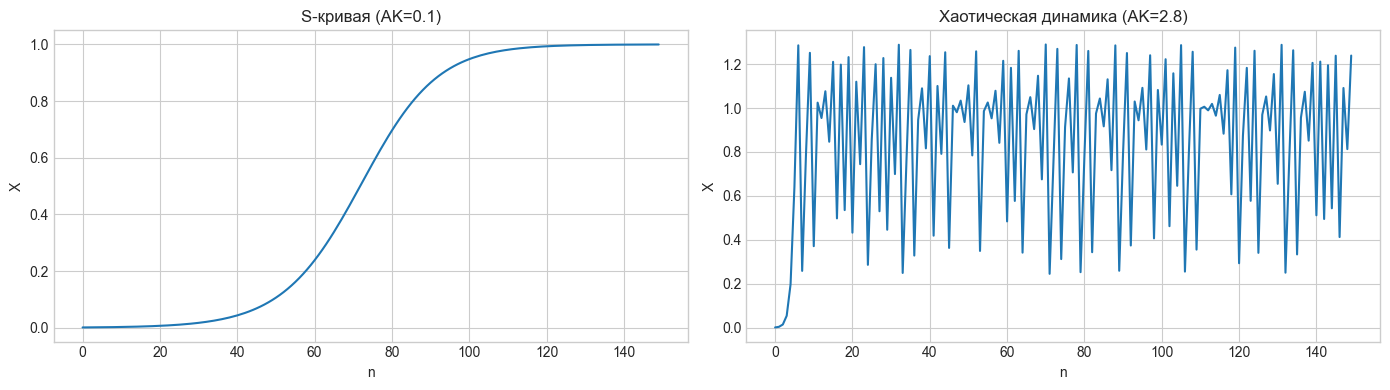

In [7]:
# --- СРАВНЕНИЕ: S-КРИВАЯ vs ХАОС ---

A_chaos = 2.8
X_chaos = generate_process_basic(A_chaos, K_sim, steps=150)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(X_data)
axes[0].set_title("S-кривая (AK=0.1)")
axes[0].set_xlabel("n")
axes[0].set_ylabel("X")

axes[1].plot(X_chaos)
axes[1].set_title("Хаотическая динамика (AK=2.8)")
axes[1].set_xlabel("n")
axes[1].set_ylabel("X")

plt.tight_layout()
plt.show()


Ниже — обновлённый **отчёт по новой версии кода и новым результатам** (со стадиями + скользящим окном + Enter/Stepwise + Beta + сравнением с хаосом). Пишу в стиле, который можно сразу вставлять в диплом как подраздел “Детализация / локальный анализ”.

---

# ОТЧЁТ ПО ЭТАПУ: ДЕТАЛИЗАЦИЯ ДИНАМИКИ (СТАДИИ ЖИЗНЕННОГО ЦИКЛА + КОРОТКИЕ ОКНА) И СРАВНЕНИЕ С ХАОСОМ

## 1. Постановка задачи и методология

В соответствии с рекомендацией научного руководителя выполнена детализация исследования базовой логистической модели Ферхюльста в форме Полунина:

$$
X_{n+1}=X_n + A X_n (K - X_n), \qquad K=1.
$$

Цель дополнения — проверить применимость регрессионного анализа **в условиях коротких выборок**, поскольку в реальной социально-экономической практике исследователь чаще наблюдает **не всю траекторию**, а лишь **локальные фрагменты**, соответствующие отдельным этапам развития процесса.

Чтобы связать “классическое” исследование режимов (стабильность/цикл/хаос) с практикой коротких рядов, использованы два взаимодополняющих подхода:

1. **Стадийная сегментация (жизненный цикл)** — выделение на S-кривой четырёх стадий по уровню освоения потенциала $X/K$:

* Зарождение: $X < 0.1K$
* Активный рост: $0.1K \le X < 0.5K$
* Насыщение: $0.5K \le X < 0.95K$
* Плато: $X \ge 0.95K$

2. **Скользящее окно фиксированной длины** ($window=25$) — моделирование ситуации, когда доступен лишь короткий временной отрезок; в каждом окне оцениваются параметры авторегрессионной модели темпов прироста с лагами до 10 (как в ТЗ).

### Переменная регрессии

Рассматривалась зависимость темпа прироста:

$$
\omega_{n+1}=\frac{X_{n+1}-X_n}{X_n}
$$

от текущего уровня $X_n$ и лагов $X_{n-1},...,X_{n-10}$. Оценивание выполнено двумя способами (терминология SPSS):

* **ENTER**: принудительное включение всех регрессоров;
* **STEPWISE**: пошаговый отбор значимых переменных.

Дополнительно рассчитаны **стандартизированные Beta-коэффициенты**, позволяющие сравнивать влияние факторов на общей шкале и выявлять доминирующие переменные в условиях мультиколлинеарности.

---

## 2. Визуальная диагностика объектов исследования

### 2.1. S-кривая и стадии жизненного цикла ($A=0.1$)

**Рисунок 1. S-образная кривая и стадии жизненного цикла.**
(вставить график: *“S-образная кривая и стадии жизненного цикла”*)

График демонстрирует классический S-образный рост с выходом на насыщение. Цветовая разметка подчёркивает, что одна и та же траектория может быть интерпретирована как последовательность **локально однородных фаз**, каждая из которых потенциально доступна для наблюдения в реальных данных.

### 2.2. Сравнение с хаосом ($A=2.8$)

**Рисунок 4. Сравнение: S-кривая ($A=0.1$) vs хаотическая динамика ($A=2.8$).**
(вставить график: *“S-кривая (AK=0.1)”* и *“Хаотическая динамика (AK=2.8)”*)

В отличие от S-кривой, хаотический режим не демонстрирует последовательных стадий роста/насыщения: колебания возникают почти сразу, а динамика визуально напоминает шум. Следовательно, **сегментация “жизненного цикла” применима именно к S-траекториям**, тогда как для хаоса “короткие данные” интерпретируются иначе — как тест устойчивости оценок и ложных корреляций.

---

## 3. Результаты локального анализа по стадиям (жизненный цикл)

### 3.1. Табличные результаты (ENTER и STEPWISE, lags=10)

Полученные оценки для четырёх стадий приведены в таблице (на основе вывода кода):

| Стадия        | Интервал | n_obs | ENTER R² | STEPWISE (выбор) | STEPWISE R² | ENTER B(X_n) | ENTER Beta(X_n) |
| ------------- | -------: | ----: | -------: | ---------------- | ----------: | -----------: | --------------: |
| Зарождение    |     0–50 |    39 | 1.000000 | [X_n]            |         1.0 |    -0.099676 |       -0.994135 |
| Активный рост |    50–72 |    11 | 1.000000 | [X_n]            |         1.0 |    -0.099873 |       -1.004154 |
| Насыщение     |   72–101 |    18 | 0.999971 | [X_n]            |         1.0 |    -0.100010 |       -1.000580 |
| Плато         |  101–150 |    38 | 1.000000 | [X_n]            |         1.0 |    -0.070943 |       -0.640854 |

**Ключевые наблюдения:**

1. **Структурная идентификация устойчива:** алгоритм Stepwise **во всех стадиях** выбирает только $X_n$. Ни один лаг $X_{n-1}...X_{n-10}$ не признан значимым, что согласуется с отсутствием памяти в базовой модели.

2. **Качество подгонки максимальное:** $R^2\approx 1$ во всех сегментах (и для ENTER, и для STEPWISE). Это соответствует тому факту, что связь $\omega$ и $X_n$ в логистическом отображении имеет точную линейную форму:
   $$
   \omega = A(K - X_n) = A - A X_n \quad (K=1).
   $$

3. **Интерпретация Beta-коэффициентов:** на стадиях зарождения/роста/насыщения $\text{Beta}(X_n)\approx -1$, то есть вклад $X_n$ доминирует и полностью определяет динамику $\omega$. Это удобно для ранжирования факторов в более сложных моделях (когда присутствуют лаги и мультиколлинеарность), и служит “эталоном” для сравнения.

4. **Особенность стадии “Плато”:** в отличие от первых трёх стадий, на стадии насыщения и плато вариативность $X_n$ падает (ряд становится почти константой), поэтому стандартизированный вклад $\text{Beta}(X_n)$ уменьшается по модулю (≈ -0.64). Это **не означает** изменения физического закона, а отражает снижение информативности регрессора в условиях малой дисперсии на плато.

---

## 4. Анализ “коротких данных” через скользящее окно

### 4.1. Дрейф оценок B(X_n) по окнам (ENTER)

**Рисунок 2. Дрейф B(X_n) по скользящему окну (ENTER), window=25, lags=10.**
(вставить график: *“Дрейф B(X_n) по скользящему окну (ENTER)”*)

Несмотря на то, что закон генерации данных неизменен, оценка коэффициента $B(X_n)$ демонстрирует **ступенчатый дрейф** при перемещении окна вдоль траектории. Этот эффект интерпретируется следующим образом:

* при переходе окна через разные области S-кривой меняется диапазон наблюдаемых значений $X_n$ и его дисперсия;
* в условиях коротких рядов (25 точек) это приводит к “локальной” перестройке оценок коэффициентов;
* наблюдаемый дрейф — это **методический эффект ограниченности данных**, а не реальный структурный сдвиг процесса.

Таким образом, даже для простого детерминированного процесса возникает важный практический вывод:

> **при коротких выборках параметры регрессии могут “плыть” без изменения закона динамики**, что требует осторожной интерпретации коэффициентов на реальных данных.

### 4.2. Частота выбора переменных Stepwise (короткие окна)

**Рисунок 3. Частота выбора переменных Stepwise (window=25, lags=10).**
(вставить график: *“Как часто Stepwise выбирает переменные”*)

На S-кривой Stepwise **почти во всех окнах** выбирает только $X_n$, а лаговые переменные не появляются. Это подтверждает робастность структурной идентификации при отсутствии памяти.

---

## 5. Сопряжение с предыдущими результатами и общий вывод

Полученные результаты дополняют основную часть главы о режимах (стабильность/цикл/хаос) следующим образом:

1. **Для S-образной траектории** (рост и насыщение) сегментация жизненного цикла корректна и позволяет имитировать практику анализа компаний на разных стадиях.

2. **Регрессионный анализ устойчив на коротких сегментах:** даже при ограниченном числе наблюдений модель корректно выявляет структуру зависимости $\omega=f(X_n)$, не “вытягивая” ложные лаги.

3. **Однако коэффициенты на коротких данных демонстрируют дрейф:** это принципиально важная оговорка для практики — изменение оценок может быть следствием ограниченности выборки и смены диапазона переменной, а не структурного сдвига.

4. **Сравнение с хаосом показывает границы интерпретации стадий:** в хаотическом режиме отсутствует смысловая последовательность “зарождение-рост-плато”, поэтому “жизненный цикл” относится к S-траекториям, а для хаоса уместны другие формы локального анализа (скользящее окно как тест нестабильности и ложных корреляций).

### Итоговый вывод

> Проведённая детализация подтвердила, что линейные регрессионные модели темпов прироста способны корректно идентифицировать базовый логистический закон даже на коротких временных фрагментах, соответствующих различным стадиям S-образного роста.
> Вместе с тем показано, что при анализе коротких окон возможно наблюдать дрейф оценок коэффициентов вследствие смены диапазона и дисперсии данных, что требует осторожной интерпретации параметров в прикладных социально-экономических задачах.
> Сравнение с хаотическим режимом подчёркивает, что стадийная интерпретация применима к траекториям роста и насыщения, тогда как для хаоса короткие окна служат инструментом методической диагностики ограничений линейной аппроксимации.

---

## Куда вставлять рисунки в текст (прямо по отчёту)

* **Рисунок 1** — сразу после описания стадий (п. 2.1).
* **Таблица стадий (life_df)** — в п. 3.1.
* **Рисунок 2 (дрейф B(X_n))** — в п. 4.1.
* **Рисунок 3 (частота Stepwise)** — в п. 4.2.
* **Рисунок 4 (S vs хаос)** — в конце п. 2.2 или в начале п. 5 как мотивация границ применимости стадий.

---
